# Roundness prediction for a centerless grinding process
The manufacturing landscape has been fundamentally transformed by Industry 4.0, revolutionizing how companies produce, enhance, and distribute their products. In today's competitive environment, where resource optimization is paramount, the integration of automation and data analytics has become essential for manufacturers. Artificial Intelligence and Machine Learning have emerged as pivotal technologies in this new era, bridging the physical and digital realms of manufacturing.
As global competition intensifies, manufacturers face mounting pressure to optimize their production processes. The ability to rapidly and automatically select optimal machine parameters during setup has become crucial for meeting escalating demands for high-quality products while minimizing resource consumption.

## Problem definition
Centerless grinding presents a unique challenge in modern manufacturing due to the inherent difficulty in predicting machined part quality based on process parameters. Unlike conventional grinding processes, centerless grinding operates without fixed workpiece positioning, introducing multiple sources of variability including vibrations and positioning inconsistencies. This fundamental characteristic makes quality prediction particularly complex.
The roundness of the worked piece — a critical quality indicator — is highly sensitive to machining parameters. Traditional trial-and-error approaches to parameter selection are increasingly inadequate in meeting modern manufacturing demands for efficiency and consistency. This creates a clear need for a more sophisticated approach to parameter optimization.
To address this challenge, this project aims to develop a regression model capable of predicting workpiece roundness based on input parameters. Such a model would serve as a fundamental tool for:

* Optimizing process parameters before machining
* Reducing setup time and material waste
* Ensuring consistent quality across production runs
* Supporting data-driven decision making in manufacturing operations

By leveraging machine learning techniques, we seek to transform the complex relationship between process parameters and workpiece roundness into a predictive model that can guide parameter selection and optimization.

## Centerless grinding process
Centerless grinding is distinguished by its unique workpiece support mechanism, which relies on a three-point contact system. This system comprises two wheels—the grinding and control wheels—and a supporting blade (work rest). This configuration allows for continuous processing without the need for individual workpiece fixturing, enabling higher production rates compared to conventional grinding methods.

<div style="text-align: center;">
<img src="figures/centerless_grinding.png" alt="Centerless Grinding Process" width="450" height="300"/>
</div>

### Process parameters
The grinding operation is governed by twelve key process parameters that directly influence the final workpiece quality:

Geometric parameters
* work piece height ($h_w$)
* workpiece length
* workpiece diameter
* grinding wheel diameter
* control wheel diameter

Kinematic parameters
* blade angle ($\gamma$)
* feed velocity
* control wheel velocity

Process-material interaction parameters
* total diameter removal
* grinding specific energy
* edge force component
* grit stiffness

### Machine characteristics
Beyond the variable process parameters, nine machine-specific parameters remain constant throughout this study:
* Grinding wheel velocity
* number of workpiece elements
* initial workpiece profile distribution
* grit diameter
* abrasive/bond ratio
* dynamic system parameters:
    * mass matrix
    * stiffness matrix
    * damping matrix
    * mode shape vector

### Data generation approach
To investigate the relationship between process parameters and workpiece quality, a high-fidelity mathematical model was employed. This model, detailed in the work of Cui et al. (2014), captures the complex physics of the centerless grinding process. The model was used to generate a comprehensive dataset for this project, with the ultimate goal of developing a regression model capable of predicting workpiece roundness based on the twelve process parameters.
The use of a high-fidelity model for data generation ensures consistent and physically valid data points while allowing exploration of a wide range of operating conditions that might be impractical or costly to test in a physical setup.

## Import libraries and data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy.stats import zscore

%config InlineBackend.figure_format = 'retina' # set 'png' here when working on notebook
%matplotlib inline # for inline plots

In [2]:
input = sio.loadmat("raw_data/InDataSet2.mat")
df_input = pd.DataFrame(input['InDataSet2'])
df_input.columns = ['wp_height','blade_angle','feed_vel','tot_diam_remov','wp_lenght','wp_diameter','grind_wheel_diam',
                    'contr_wheel_diam','contr_wheel_vel','grind_spec_energy','edge_force_comp','grit_stiff']

output = sio.loadmat("raw_data/OutDataSetRound_Hi.mat")
df_output = pd.DataFrame(output['OutDataSetRound_Hi'])
df_output.columns = ['Hi_fidelity_output']

df_complete = pd.concat([df_input, df_output], axis=1)

## Data inspection
Data inspection representes the foundational building block of any data science project.
During this phase, the data are analysed to understand their characteristics and structure before applying predictive models. 
In particular, the inspection process follows a systematic approach:

Data overview
* creation of a backup copy to preserve the original data state
* initial dataset exploration to understand the input-output of the problem
* assesment of dataset dimensions and basic properties (such as cardinality, basic statistics, ecc.)

Data quality analysis
* identification of the missing values and their patterns
* detection of duplicate records
* validation of data consistency and integrity (Are data coherent? Do they respect the business constraints? ecc.)
* evaluation of data quality and reliability (Do we have all necessary data? Are they recent? Is the sample representative?)

Variable analysis
* classification of features by type (categorical/numerical, discrete/continuous)
* examination of varibale distribution and descriptive statistics
* detection and analysis of outliers
* assesment of variable scales and potential normalization needs
* analysis of categorical variable cardinality

Relationship assesment
* investigation of correlation between features
* identification of potential multicollinearity
* analysis of target distribution and class balance
* exploration of feature-target relationships

This inspection phase provides the foundation for subsequent data preprocessing and modeling decisions, ensuring that potential issues are identified and solved early in the project lifecycle.


### Data overview
* creation of a backup copy to preserve the original data state
* initial dataset exploration to understand the input-output of the problem
* assesment of dataset dimensions and basic properties (such as cardinality, basic statistics, ecc.)

In [3]:
df = df_complete.copy() # make a copy of the original data

In [4]:
df.describe() # summary statistics

,wp_height,blade_angle,feed_vel,tot_diam_remov,wp_lenght,wp_diameter,grind_wheel_diam,contr_wheel_diam,contr_wheel_vel,grind_spec_energy,edge_force_comp,grit_stiff,Hi_fidelity_output
count,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000
mean,7.500000,28.000488,0.013500,29.997314,85.000000,32.500000,400.000000,275.000000,20.000000,25000.000000,2.500000,400.000000,8.553068
std,7.217759,7.483380,0.006640,29.602449,37.532348,15.879070,57.742074,43.306556,5.774207,8661.311133,1.443552,115.484148,7.750870
min,-4.996948,20.000000,0.002003,2.000000,20.015869,5.006714,300.024414,200.018311,10.002441,10003.662109,0.000610,200.048828,0.074228
25%,1.251526,20.000000,0.007751,12.000000,52.507935,18.753357,350.012207,237.509155,15.001221,17501.831055,1.250305,300.024414,3.880525
50%,7.500000,30.000000,0.013500,20.000000,85.000000,32.500000,400.000000,275.000000,20.000000,25000.000000,2.500000,400.000000,6.987628
75%,13.748474,30.000000,0.019249,36.000000,117.492065,46.246643,449.987793,312.490845,24.998779,32498.168945,3.749695,499.975586,11.357380
max,19.996948,40.000000,0.024997,233.000000,149.984131,59.993286,499.975586,349.981689,29.997559,39996.337891,4.999390,599.951172,247.346615


In [5]:
df.head() # show the first 5 rows

,wp_height,blade_angle,feed_vel,tot_diam_remov,wp_lenght,wp_diameter,grind_wheel_diam,contr_wheel_diam,contr_wheel_vel,grind_spec_energy,edge_force_comp,grit_stiff,Hi_fidelity_output
0,6.294556,40.0,0.023139,18.0,49.151611,6.953735,334.106445,222.247314,16.145020,34810.791016,4.900513,384.521484,3.139700
1,12.056274,20.0,0.009617,13.0,117.293701,15.023804,308.862305,255.902100,20.334473,36568.603516,0.848999,289.208984,4.364352
2,-3.568726,40.0,0.014660,10.0,29.759521,45.276489,372.875977,263.262939,26.179199,36370.849609,2.658081,485.595703,3.438761
3,1.356812,20.0,0.013362,13.0,42.962646,39.072876,499.243164,334.197998,28.937988,18924.560547,4.026489,310.986328,1.716082
4,15.718384,30.0,0.014401,6.0,86.126709,46.323853,488.256836,214.007568,19.172363,16456.298828,1.771851,206.689453,5.781276


The dataset consists of 4096 records collected from a centerless grinding process, with 12 input features representing various process parameters and a single output variable measuring the worked piece roundness. A preliminary analysis reveals that all variables are numerical. However, there are significant scales differences across the features. For instance, the work piece height ranges up to 19.99 units, while the total diameter removal reaches values as high as 233 units.
The variance disparity among features is particularly noteworthy with the feed velocity showing minimal variation (standard deviation is 0.01) compared to the grinding specific energy, which exhibits substantial fluctuations (standard deviation is 25000).
Another interesting observation emerged regarding the work piece height measurements, where negative values were detected in the minimum range. This peculiarity was investigated through consultation with Eng. Researcher (CNR-STIIMA Milano) Marco Leaonesio, the data provider and domain expert, who validated the accuracy of these measurements, attributing them to the specific characteristics of the measuring instrumentation used in the process.

The presence of such scale disparities and variance differences suggests that feature scaling might be necessary in subsequent preprocessing phases to ensure optimal algorithm performance.

### Data quality analysis
* identification of the missing values and their patterns
* detection of duplicate records
* validation of data consistency and integrity (Are data coherent? Do they respect the business constraints? ecc.)
* evaluation of data quality and reliability (Do we have all necessary datas? Are they recent? Is the sample representative?)

In [6]:
print("% OF MISSING VALUES")
print(df.isna().sum() / len(df) * 100) # percentage of missing values
print("N° OF DUPLICATED VALUES")
print(f"Duplicated: {df.duplicated().sum()}") # number of duplicated rows

% OF MISSING VALUES
wp_height             0.0
blade_angle           0.0
feed_vel              0.0
tot_diam_remov        0.0
wp_lenght             0.0
wp_diameter           0.0
grind_wheel_diam      0.0
contr_wheel_diam      0.0
contr_wheel_vel       0.0
grind_spec_energy     0.0
edge_force_comp       0.0
grit_stiff            0.0
Hi_fidelity_output    0.0
dtype: float64
N° OF DUPLICATED VALUES
Duplicated: 0


The dataset was generated through a high-fidelity mathematical simulation of the process, ensuring complete data integrity with no missing values or duplicate entries. This synthetic data generation approach guarantees the dataset's completeness and consistency.

### Variable analysis
* classification of features by type (categorical/numerical, discrete/continuous)
* examination of varibale distribution and descriptive statistics
* detection and analysis of outliers
* assesment of variable scales and potential normalization needs
* analysis of categorical cariable cardinality

In [7]:
df.dtypes

wp_height             float64
blade_angle           float64
feed_vel              float64
tot_diam_remov        float64
wp_lenght             float64
wp_diameter           float64
grind_wheel_diam      float64
contr_wheel_diam      float64
contr_wheel_vel       float64
grind_spec_energy     float64
edge_force_comp       float64
grit_stiff            float64
Hi_fidelity_output    float64
dtype: object

In [8]:
df.nunique() # number of unique values in each column

wp_height             4096
blade_angle              3
feed_vel              4096
tot_diam_remov         172
wp_lenght             4096
wp_diameter           4096
grind_wheel_diam      4096
contr_wheel_diam      4096
contr_wheel_vel       4096
grind_spec_energy     4096
edge_force_comp       4096
grit_stiff            4096
Hi_fidelity_output    4096
dtype: int64

All features in the dataset are stored as numerical values using float64 precision. A detailed analysis of the unique values for each variable revealed that the blade angle stands out by taking only three discrete values. This distinguished it as the sole categorical variable in an otherwise continuous feature set.

<Figure size 2000x1000 with 0 Axes>

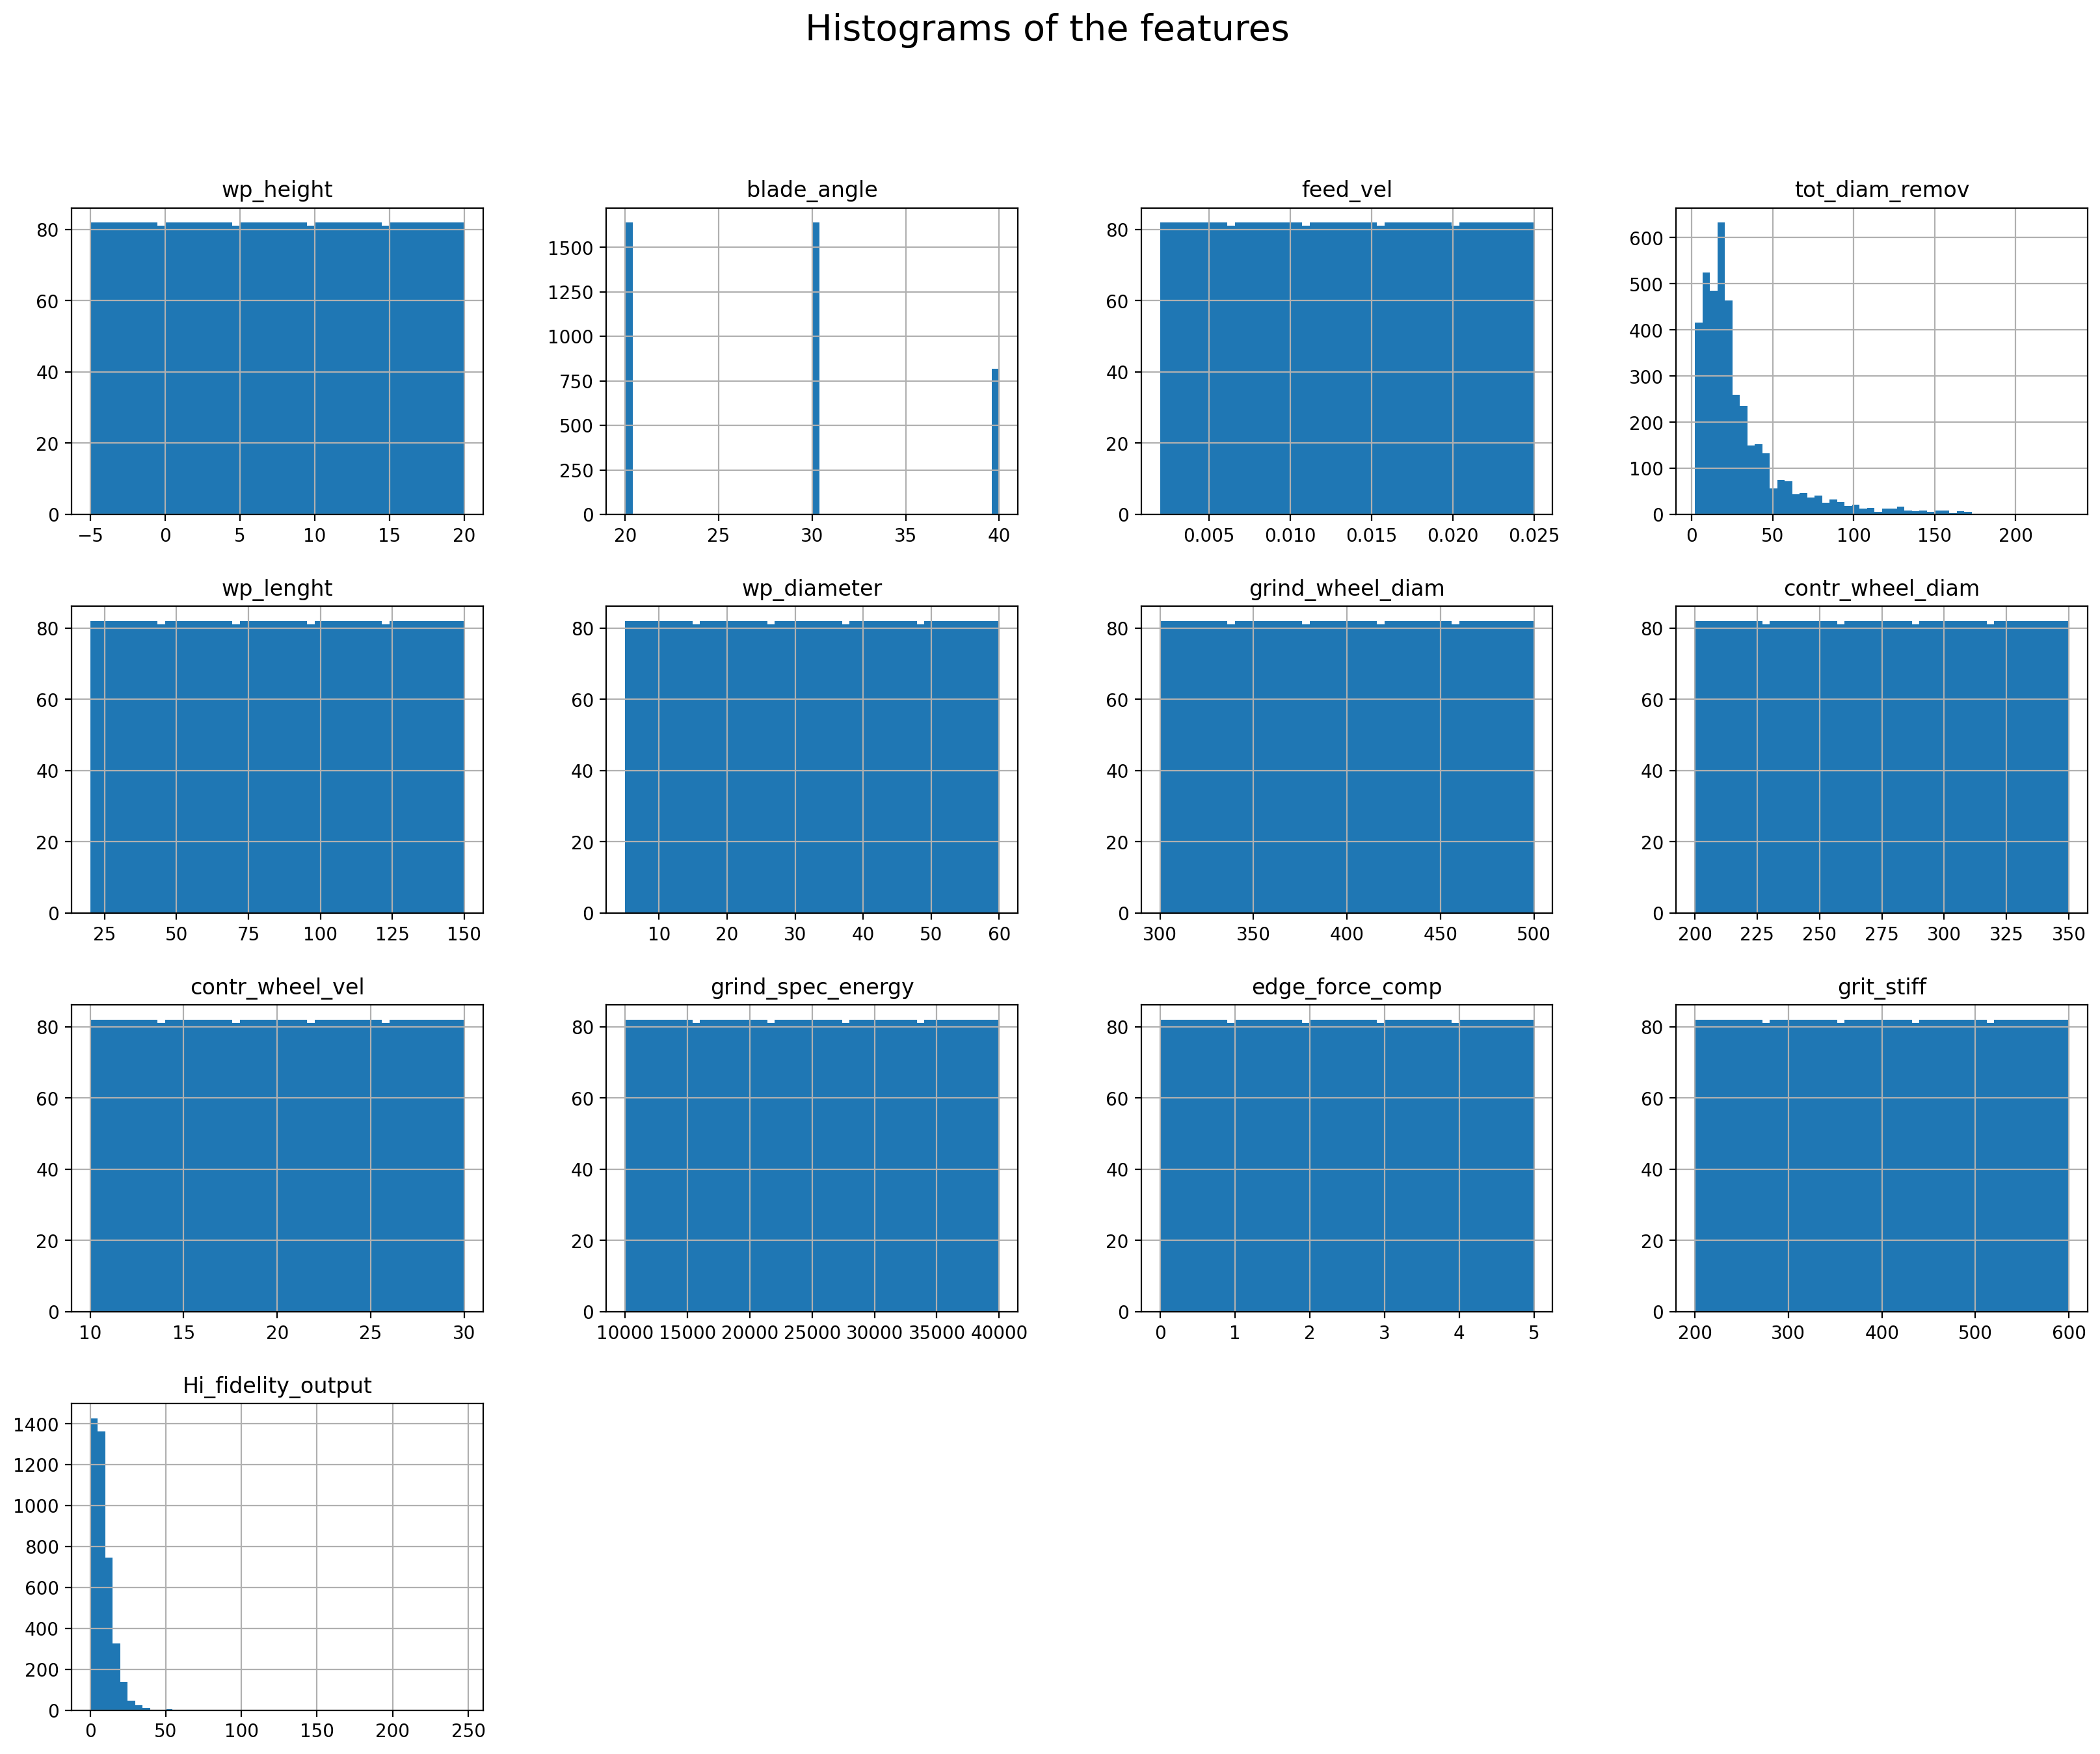

In [9]:
plt.figure(figsize=(20,10))
df.hist(bins=50, figsize=(20,15))
plt.suptitle("Histograms of the features", fontsize=20)
plt.show()

The distribution analysis of the features reveals distinct patterns in their statistical behavior. Most features exhibit uniform distributions across their respective ranges. The blade angle maintains its discrete nature with three distinct values (20°, 30°, and 40°), as previously identified. Of particular interest are the total diameter removal and the target variable (worked piece roundness -  output from the high-fidelity model) which display Gaussian-like distributions with pronounced asymmetry.

In [10]:
numerical_features = df.select_dtypes(include=[np.number]).columns
skewed_features = df[numerical_features].apply(lambda x: np.round(x.skew(), 3)).sort_values(ascending=False)
skewed_features = pd.DataFrame({'Skewness': skewed_features})
skewed_features

,Skewness
Hi_fidelity_output,9.003
tot_diam_remov,2.463
blade_angle,0.344
wp_height,0.000
feed_vel,0.000
wp_lenght,0.000
wp_diameter,0.000
grind_wheel_diam,0.000
contr_wheel_diam,0.000
contr_wheel_vel,0.000


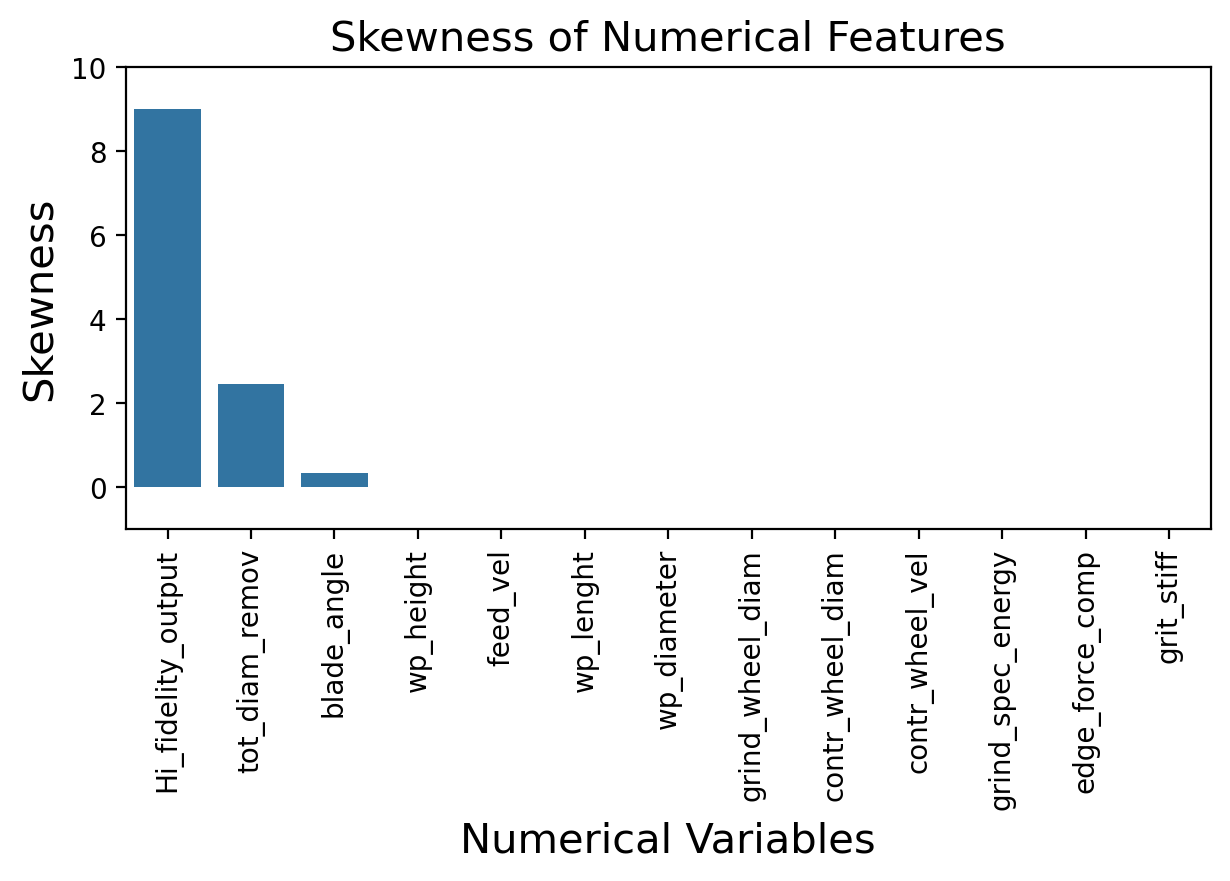

In [11]:
f, ax = plt.subplots(figsize=(7,3))
plt.xticks(rotation=90)
sns.barplot(x=skewed_features.index, y=skewed_features['Skewness'])
plt.ylim(0,25)
plt.xlabel('Numerical Variables', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.ylim(min(skewed_features['Skewness'])-1, max(skewed_features['Skewness'])+1)
plt.title('Skewness of Numerical Features', fontsize=15)
plt.show()

The skewness analysis quantitatively validates the asymmetric patterns previously observed in the histograms, particularly confirming positive skewness in both the target variable and the total diameter removal feature. This asymmetric distribution not only suggests potential outlier presence but also raises concerns about the applicability of models that rely on symmetrical data distributions, such as linear regression.

To address these distributional challenges, a log1p transformation ( $ln(x + 1)$ ) will be applied to the total diameter removal feature. This transformation technique effectively reduces skewness and brings the distribution closer to symmetrical. While the same transformation could theoretically be applied to the target variable, this option was deliberately avoided to preserve the direct interpretability of the model's predictions, which is considered a priority for this project's objectives.
The decision to maintain the original scale of the target variable represents a conscious trade-off between optimal statistical properties and practical usability of the model's results.

In [12]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outliers_IQR = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))) # number of outliers per column detected with the IQR method
print("Outliers for columns detected with the IQR method:\n", outliers_IQR.sum())

Outliers for columns detected with the IQR method:
 wp_height               0
blade_angle             0
feed_vel                0
tot_diam_remov        345
wp_lenght               0
wp_diameter             0
grind_wheel_diam        0
contr_wheel_diam        0
contr_wheel_vel         0
grind_spec_energy       0
edge_force_comp         0
grit_stiff              0
Hi_fidelity_output    141
dtype: int64


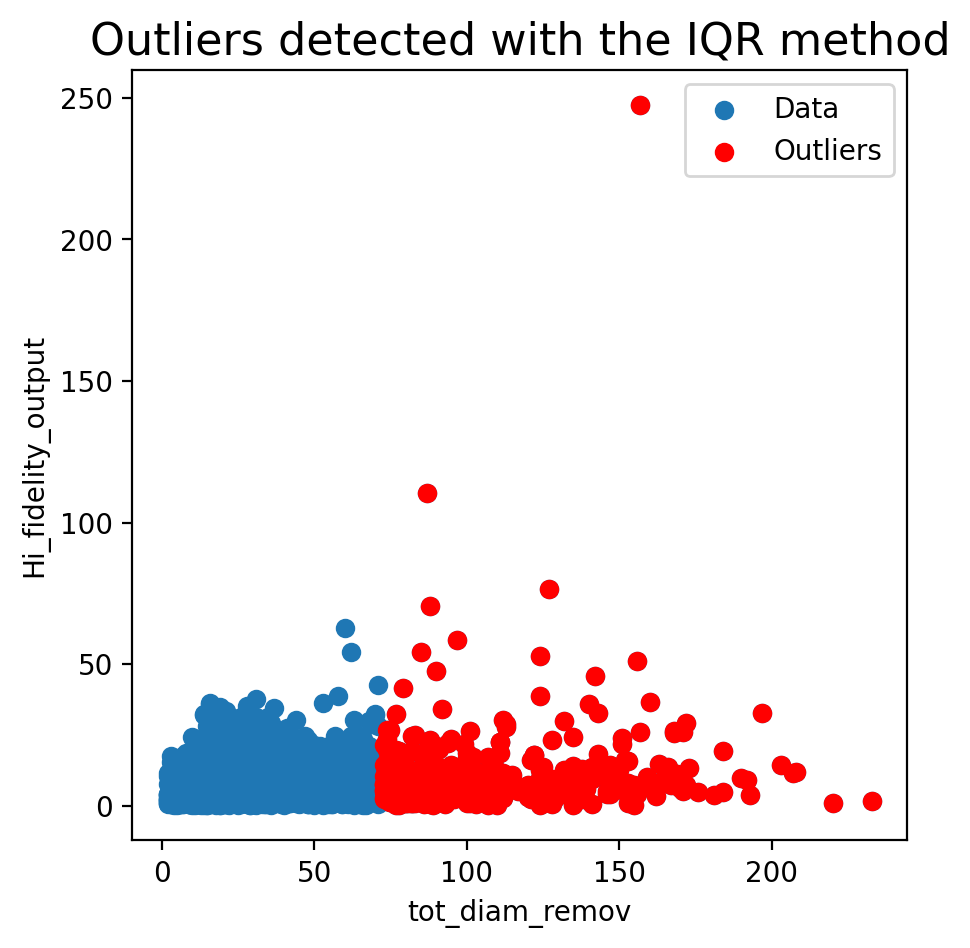

In [13]:
outliers_IQR_index = outliers_IQR.tot_diam_remov[outliers_IQR.tot_diam_remov == True].index

plt.figure(figsize=(5,5))
plt.scatter(df['tot_diam_remov'], df['Hi_fidelity_output'])
plt.scatter(df.tot_diam_remov.iloc[outliers_IQR_index], df.Hi_fidelity_output.iloc[outliers_IQR_index], color='red')
plt.title('Outliers detected with the IQR method', fontsize=16)
plt.xlabel('tot_diam_remov')
plt.ylabel('Hi_fidelity_output')
plt.legend(['Data', 'Outliers'])
plt.show()

In [14]:
outliers_zscore = df.select_dtypes(include=['int64', 'float64']).apply(zscore) # number of outliers per column detected with the Z-score method
outliers_zscore = ((outliers_zscore < -3) | (outliers_zscore > 3))
print("Outliers for columns detected with the z-score method:\n", outliers_zscore.sum())

Outliers for columns detected with the z-score method:
 wp_height               0
blade_angle             0
feed_vel                0
tot_diam_remov        117
wp_lenght               0
wp_diameter             0
grind_wheel_diam        0
contr_wheel_diam        0
contr_wheel_vel         0
grind_spec_energy       0
edge_force_comp         0
grit_stiff              0
Hi_fidelity_output     34
dtype: int64


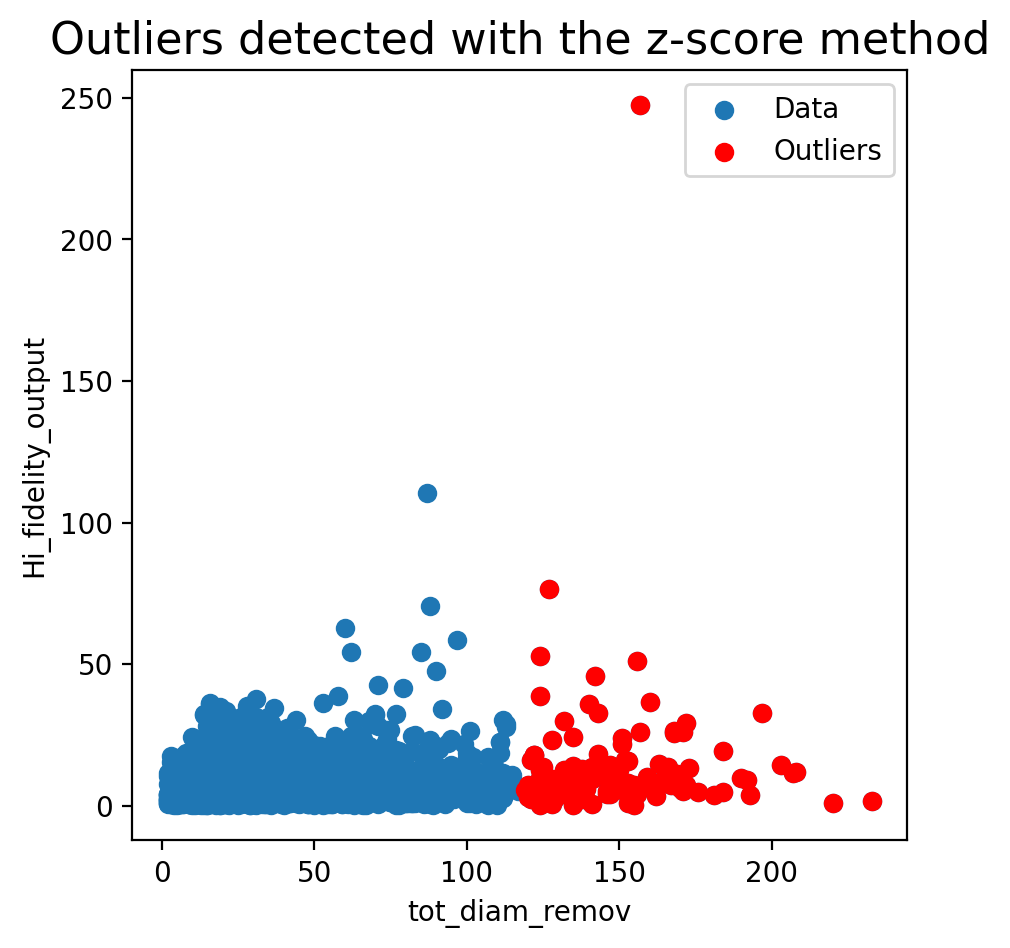

In [15]:
outliers_zscore_index = outliers_zscore.tot_diam_remov[outliers_zscore.tot_diam_remov == True].index

plt.figure(figsize=(5,5))
plt.scatter(df['tot_diam_remov'], df['Hi_fidelity_output'])
plt.scatter(df.tot_diam_remov.iloc[outliers_zscore_index], df.Hi_fidelity_output.iloc[outliers_zscore_index], color='red')
plt.title('Outliers detected with the z-score method', fontsize=16)
plt.xlabel('tot_diam_remov')
plt.ylabel('Hi_fidelity_output')
plt.legend(['Data', 'Outliers'])
plt.show()

The outlier detection phase involved a comparative analysis of two widely used methods: the Interquartile Range (IQR) and the z-score approach. The IQR method emerged as the more suitable choice for this dataset, particularly due to its robustness in handling non-normal distributions and its reduced sensitivity to extreme values. This characteristic is especially relevant given the observed skewness in the total diameter removal variable. The difference in sensitivity between the two methods is evident in their results: the IQR method identified 345 potential outliers in the total diameter removal feature, while the z-score approach detected only 117.
However, the nature of our dataset - being generated through a high-fidelity simulation model - provides an important context for interpreting these results. In synthetic data generated from validated mathematical models, points flagged as statistical outliers often represent valid process conditions rather than errors. Therefore, despite their statistical deviation from the main distribution, all data points are retained for subsequent analysis, as they represent legitimate scenarios within the process model.

### Relationship assesment
* investigation of correlation between features
* identification of potential multicollinearity
* analysis of target distribution and class balance
* exploration of feature-target relationships

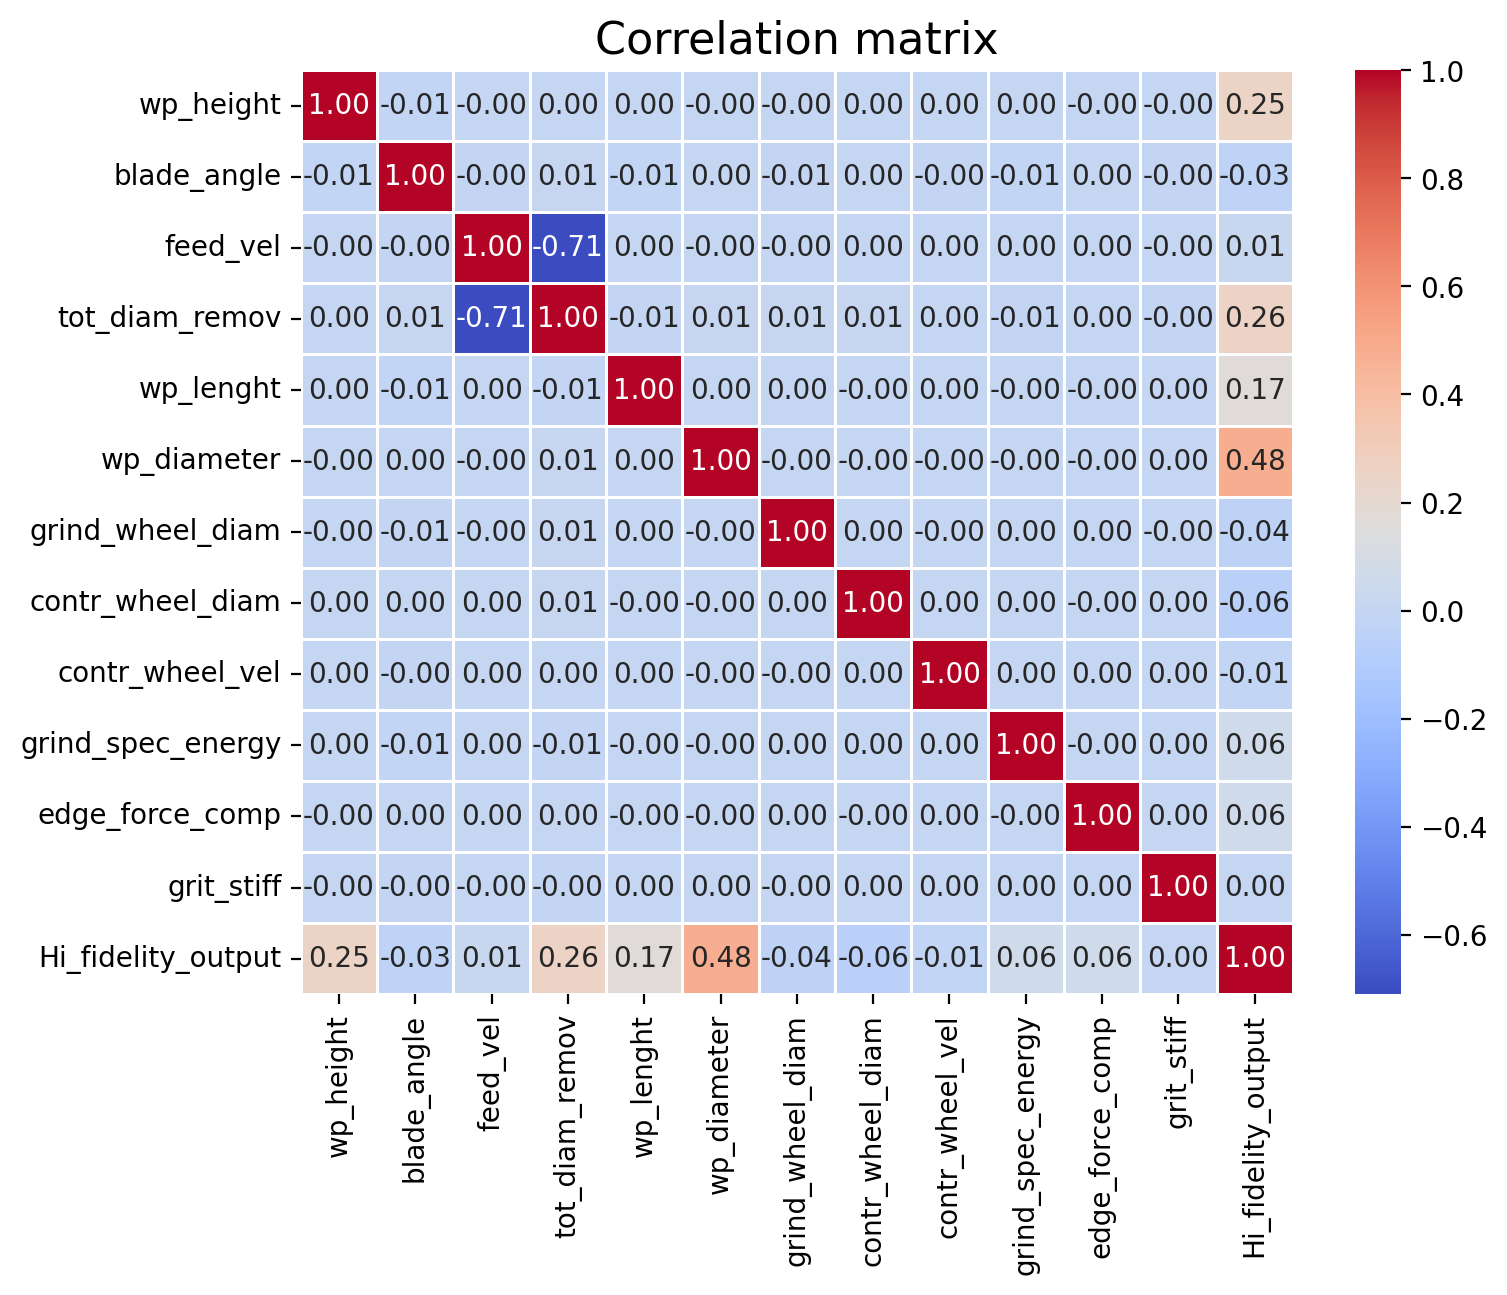

In [16]:
corr_matrix = df.corr(method='spearman')
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation matrix", fontsize=16)
plt.show()

To investigate the relationships between variables, a correlation analysis was performed using the Spearman correlation coefficient. This non-parametric measure was selected over the Pearson coefficient due to the non-normal distribution of both the target variable and the total diameter removal feature, despite the continuous nature of most variables (with the blade angle being the only discrete feature).
The correlation structure is visualized through a heatmap, employing a red-blue color scheme where red indicates positive correlations and blue represents negative ones. The analysis reveals several notable patterns:

1. most features exhibit weak or negligible correlations with each other, suggesting limited multicollinearity in the dataset
2. four features show significant correlations with the target variable:
    * work piece height
    * work piece length
    * work piece diameter
    * total diameter removal
3. a notable negative correlation exists between the total diameter removal and feed rate

These correlation patterns align with the physical principles governing the centerless grinding process, providing additional validation of the data's consistency with domain knowledge. The limited correlation among most features suggests that they likely contribute independent information to the process, which could be beneficial for subsequent modeling phases.

# Save the data

In [ ]:
df.to_csv('CenterlessGrindingData.csv')